# *Planet: Understanding the Amazon from Space* challenge

This notebook will show you how to do some basic manipulation of the images and label files.

In [1]:
import sys
import os
import subprocess

# Make sure you have all of these packages installed, e.g. via pip
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from scipy import ndimage
from IPython.display import display
%matplotlib inline

## Setup
Set `PLANET_KAGGLE_ROOT` to the directory where you've downloaded the TIFF and JPEG zip files, and accompanying CSVs.

In [5]:
PLANET_KAGGLE_ROOT = os.path.abspath("./data/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, './jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, './tif/', './labels.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

## Inspect image labels
The labels are in a CSV entitled `labels.csv`. Note that each image can be tagged with multiple tags. We'll convert them to a "one hot" style representation where each label is a column:

In [6]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,id,tags
0,20170130_192121_1_0c54_0_16.tif,clear primary road water
1,20160827_142408_0e0f_4_1.tif,agriculture bare_ground clear primary road
2,20160921_123846_0c76_2_17.tif,clear primary
3,20170119_125238_0e0e_5_10.tif,agriculture clear habitation primary road
4,20161023_124839_0e1f_7_11.tif,agriculture partly_cloudy primary road


In [7]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [8]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,id,tags,clear,primary,road,water,agriculture,bare_ground,habitation,partly_cloudy,cultivation,haze,blooming,cloudy,artisinal_mine,selective_logging,slash_burn,conventional_mine,blow_down
0,20170130_192121_1_0c54_0_16.tif,clear primary road water,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20160827_142408_0e0f_4_1.tif,agriculture bare_ground clear primary road,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,20160921_123846_0c76_2_17.tif,clear primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20170119_125238_0e0e_5_10.tif,agriculture clear habitation primary road,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,20161023_124839_0e1f_7_11.tif,agriculture partly_cloudy primary road,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0


Now, let's look at the labels' frequencies, and which ones cooccur. You'll notice that the classes are very uneven, e.g. the weather related tags are much more frequent than the land use tags, e.g. selective_logging)

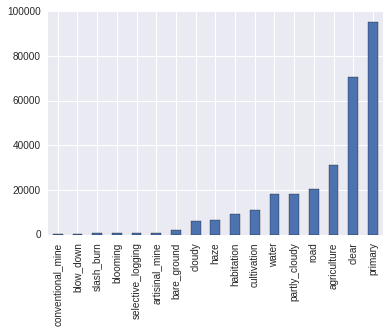

In [9]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

,clear,primary,road,water,agriculture,bare_ground,habitation,partly_cloudy,cultivation,haze,blooming,cloudy,artisinal_mine,selective_logging,slash_burn,conventional_mine,blow_down
clear,70741,69497,15650,13152,22824,1798,7496,0,8795,0,763,0,749,725,503,157,209
primary,69497,95163,19449,17628,30191,1677,8578,18161,11107,6649,811,856,802,825,588,224,239
road,15650,19449,20220,5421,15238,783,6797,3513,3247,1039,24,18,292,360,96,142,8
water,13152,17628,5421,18142,6772,518,2264,3240,2092,1513,45,237,748,92,68,55,6
agriculture,22824,30191,15238,6772,31015,555,6847,6379,8427,1729,63,83,93,146,311,49,44
bare_ground,1798,1677,783,518,555,2083,367,165,225,120,10,0,93,34,36,28,11
habitation,7496,8578,6797,2264,6847,367,8989,1111,2082,375,7,7,80,36,116,80,4
partly_cloudy,0,18161,3513,3240,6379,165,1111,18331,1857,0,38,0,70,80,73,70,30
cultivation,8795,11107,3247,2092,8427,225,2082,1857,11161,509,78,0,54,129,360,13,16
haze,0,6649,1039,1513,1729,120,375,0,509,6725,10,0,18,20,12,8,0


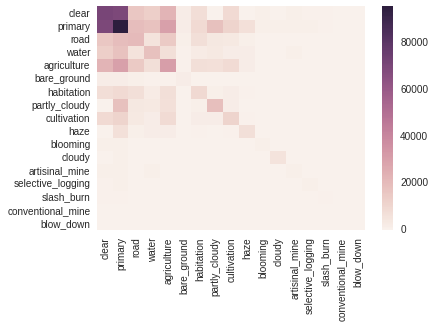

In [10]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

Each image should have exactly one weather label:

,clear,partly_cloudy,haze,cloudy
clear,70741,0,0,0
partly_cloudy,0,18331,0,0
haze,0,0,6725,0
cloudy,0,0,0,5873


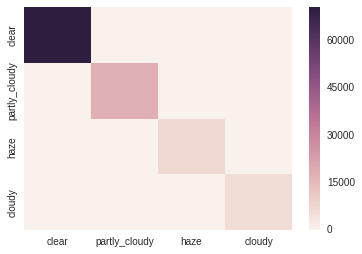

In [11]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

But the land labels may overlap:

,primary,agriculture,water,cultivation,habitation
primary,95163,30191,17628,11107,8578
agriculture,30191,31015,6772,8427,6847
water,17628,6772,18142,2092,2264
cultivation,11107,8427,2092,11161,2082
habitation,8578,6847,2264,2082,8989


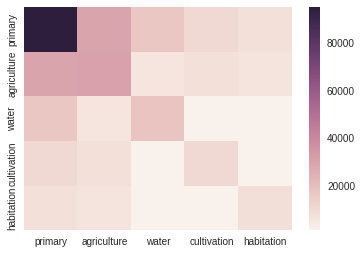

In [12]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

The rarer labels have very little overlap:

,blooming,artisinal_mine,selective_logging,slash_burn,conventional_mine,blow_down
blooming,811,0,11,3,0,1
artisinal_mine,0,837,14,1,12,0
selective_logging,11,14,825,4,2,6
slash_burn,3,1,4,588,1,2
conventional_mine,0,12,2,1,235,0
blow_down,1,0,6,2,0,239


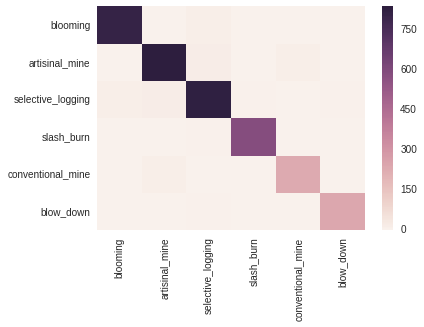

In [13]:
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)

## Inspect images
Let's display an image and visualize the pixel values. Here we will pick an image, load every single single band,
then create RGB stack. These raw images are 16-bit (from 0 to 65535), and contain red, green, blue, and [Near infrared (NIR)](https://en.wikipedia.org/wiki/Infrared#Regions_within_the_infrared) channels. In this example, we are discarding the NIR band just to simplify the steps to visualize the image. However, you should probably keep it for ML classification.

The files can be easily read into numpy arrays with the [rasterio](https://mapbox.github.io/rasterio/) library. The code below assumes you've extracted the zip files into directories at `PLANET_KAGGLE_ROOT`.

In [14]:
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, basestring):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [15]:
def load_image(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            with rasterio.open(path) as src:
                b, g, r, nir = src.read()
                return np.dstack([r, g, b, nir])

Let's look at an individual image. First, we'll plot a histogram of pixel values in each channel. Note how the intensities are distributed in a relatively narrow region of the dynamic range

/usr/local/lib/python2.7/dist-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


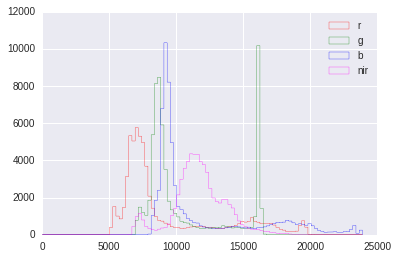

In [19]:
image_path = sample_images(['primary', 'water', 'road'], n=1)['id'].iloc[0]
image_path = "20170208_164354_0c65_6_13.tif"
rgbn_image = load_image(image_path)
rgb_image = rgbn_image[:,:,:3]
r, g, b, nir = rgbn_image[:, :, 0], rgbn_image[:, :, 1], rgbn_image[:, :, 2], rgbn_image[:, :, 3]
for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'), (nir, 'nir', 'magenta')):
    plt.hist(slice_.ravel(), bins=100, 
             range=[0,rgb_image.max()], 
             label=name, color=color, histtype='step')
plt.legend()

We can look at each channel individually:

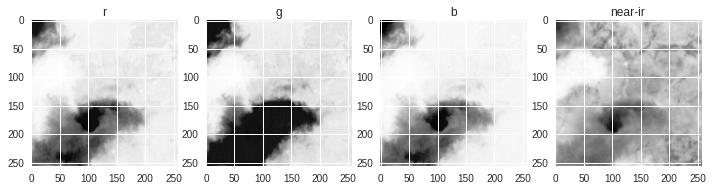

In [20]:
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

But, when we try to look at the RGB image, something funny's going on!

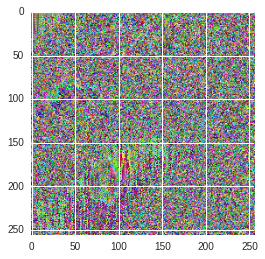

In [21]:
plt.imshow(rgb_image)

### Calibrate colors for visual inspection

Yikes! That does not look pretty. This is not a problem for analytic purposes, but we can try some transformations to make the image look better for visual inspection.

One way of doing this is to normalize the image channels to a reference color curve. We'll show here how to estimate a reference color curve from other normalized images. We could choose a third party aerial image of a canopy , but here we will employ the JPEG images provided in the data set, which have already been color-corrected.  

In essence, the idea is to transform the pixel values of the test image so that their average and variance match the reference image data.

Get a list of reference images to extract data from:

In [22]:
# Pull a list of 20000 image names
jpg_list = subprocess.check_output('ls ' + PLANET_KAGGLE_JPEG_DIR + ' | head -20000', shell=True).split('\n')[:-1]
# Select a random sample of 100 among those
np.random.shuffle(jpg_list)
jpg_list = jpg_list[:100]

Read each image (8-bit RGBA) and dump the pixels values to ref_colors, which contains buckets for R, G and B

In [23]:
ref_colors = [[],[],[]]
for _file in jpg_list:
    # keep only the first 3 bands, RGB
    _img = mpimg.imread(os.path.join(PLANET_KAGGLE_JPEG_DIR, _file))[:,:,:3]
    # Flatten 2-D to 1-D
    _data = _img.reshape((-1,3))
    # Dump pixel values to aggregation buckets
    for i in range(3): 
        ref_colors[i] = ref_colors[i] + _data[:,i].tolist()
    
ref_colors = np.array(ref_colors)

Visualize the histogram of the reference data

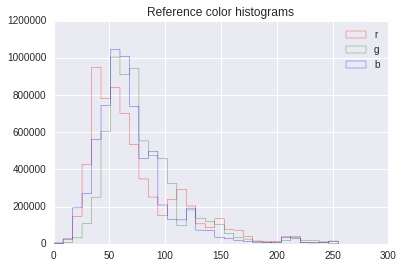

In [24]:
for i,color in enumerate(['r','g','b']):
    plt.hist(ref_colors[i], bins=30, range=[0,255], label=color, color=color, histtype='step')
plt.legend()
plt.title('Reference color histograms')

Compute the mean and variance for each channel in the reference data

In [25]:
ref_means = [np.mean(ref_colors[i]) for i in range(3)]
ref_stds = [np.std(ref_colors[i]) for i in range(3)]

And now, we have a function that can calibrate any raw image reasonably well:

In [26]:
def calibrate_image(rgb_image):
    # Transform test image to 32-bit floats to avoid 
    # surprises when doing arithmetic with it 
    calibrated_img = rgb_image.copy().astype('float32')

    # Loop over RGB
    for i in range(3):
        # Subtract mean 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]-np.mean(calibrated_img[:,:,i])
        # Normalize variance
        calibrated_img[:,:,i] = calibrated_img[:,:,i]/np.std(calibrated_img[:,:,i])
        # Scale to reference 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]*ref_stds[i] + ref_means[i]
        # Clip any values going out of the valid range
        calibrated_img[:,:,i] = np.clip(calibrated_img[:,:,i],0,255)

    # Convert to 8-bit unsigned int
    return calibrated_img.astype('uint8')

Visualize the color histogram of the newly calibrated test image, and note that it's more evenly distributed throughout the dynamic range, and is closer to the reference data.

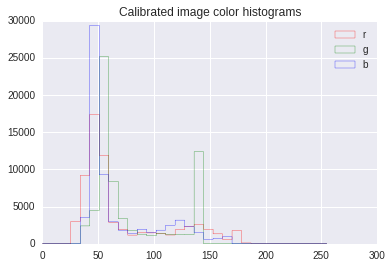

In [27]:
test_image_calibrated = calibrate_image(rgb_image)
for i,color in enumerate(['r','g','b']):
    plt.hist(test_image_calibrated[:,:,i].ravel(), bins=30, range=[0,255], 
             label=color, color=color, histtype='step')
plt.legend()
plt.title('Calibrated image color histograms')

And now we have something we can recognize!

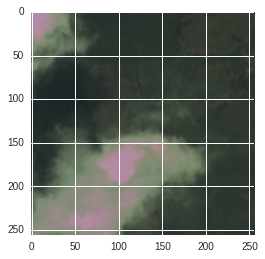

In [28]:
plt.imshow(test_image_calibrated)

Putting it all together, to show several images with your tags of choice:

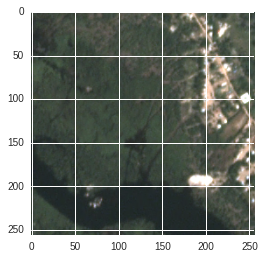

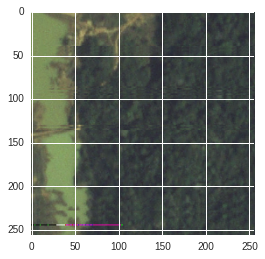

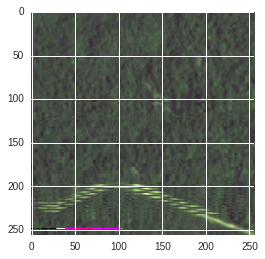

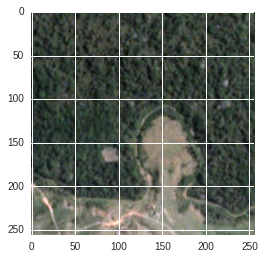

In [34]:
sampled_images = sample_images(['clear', 'road', 'water'], n=100)
for img_name in sampled_images['id']:
    try:
        rgb_img = load_image(img_name)[:,:,:3]
        plt.figure()
        plt.imshow(calibrate_image(rgb_img))
    except:
        continue

## Image modification

You might want to rotate, flip, or otherwise modify the images for training purposes. Note that the dimensions of the image changes:

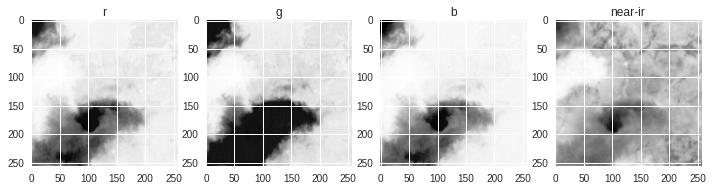

In [35]:
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

(362, 362, 3)

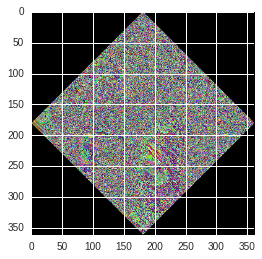

In [36]:
rotated = scipy.ndimage.rotate(rgb_image, angle=45)
plt.imshow(rgb_image)
plt.imshow(rotated)
rotated.shape

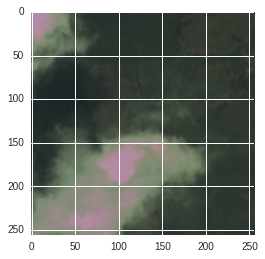

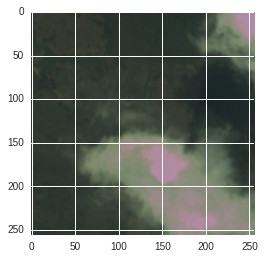

In [37]:
plt.imshow(calibrate_image(rgb_image))
plt.figure()
plt.imshow(calibrate_image(np.fliplr(rgb_image)))


Original Notebook by Jesus Martinez Manso and Benjamin Goldenberg

(C) Planet 2017